# Train and evaluate on MNIST

In [1]:
import sys
sys.path.append('models')

In [2]:
import models.ExampleModels as em
import torch
import matplotlib.pyplot as plt 
import numpy as np

# Get Data

In [3]:
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader,random_split

In [4]:
data_dir = 'dataset'

train_dataset = torchvision.datasets.MNIST(data_dir, train=True, download=True)
test_dataset  = torchvision.datasets.MNIST(data_dir, train=False, download=True)

In [5]:
train_transform = transforms.Compose([
transforms.ToTensor(),
])

test_transform = transforms.Compose([
transforms.ToTensor(),
])

train_dataset.transform = train_transform
test_dataset.transform = test_transform

m=len(train_dataset)

#train_data, val_data = random_split(train_dataset, [int(m-m*0.2), int(m*0.2)])
batch_size=32

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
#valid_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,shuffle=True)

# Train Model

In [6]:
ae = em.AutoEncoder(40,use_sq_dr= True,dr_min_p= .2, scale_output=False)

Selected device: cpu


In [9]:
def plot_ae_outputs(ae,n=10):
    plt.figure(figsize=(16,4.5))
    encoder = ae.encoder
    decoder = ae.decoder
    device = ae.device
    targets = test_dataset.targets.numpy()
    t_idx = {i:np.where(targets==i)[0][0] for i in range(n)}
    for i in range(n):
        ax = plt.subplot(2,n,i+1)
        img = test_dataset[t_idx[i]][0].unsqueeze(0).to(device)
        encoder.eval()
        decoder.eval()
        with torch.no_grad():
            rec_img  = decoder(encoder(img))
        plt.imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)  
        if i == n//2:
            ax.set_title('Original images')
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')  
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)  
        if i == n//2:
            ax.set_title('Reconstructed images')
    plt.show()   


 EPOCH 1/25 	 train loss 0.01576346345245838 	 val loss 0.01749630644917488


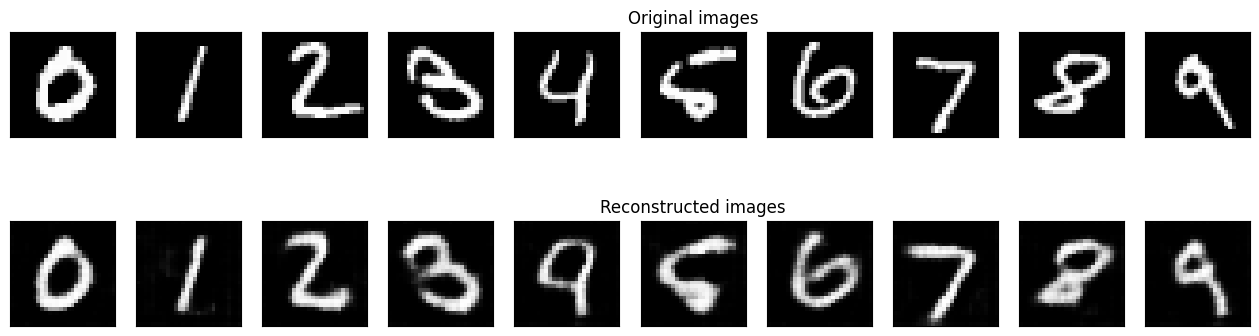


 EPOCH 2/25 	 train loss 0.013707446865737438 	 val loss 0.014149432070553303


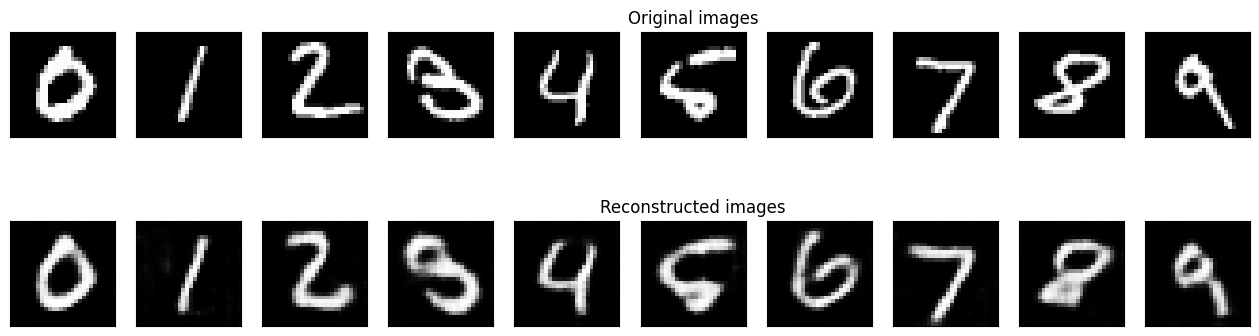


 EPOCH 3/25 	 train loss 0.012874919921159744 	 val loss 0.014822453260421753


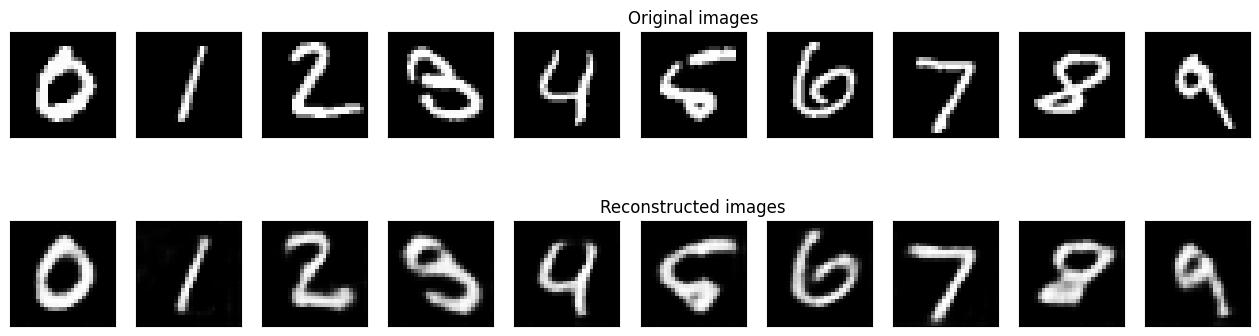


 EPOCH 4/25 	 train loss 0.012366360053420067 	 val loss 0.012535805813968182


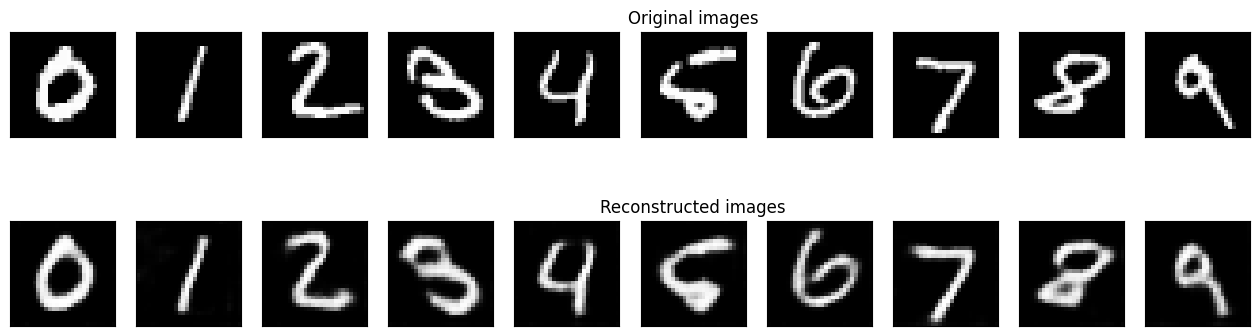


 EPOCH 5/25 	 train loss 0.012057916261255741 	 val loss 0.013798692263662815


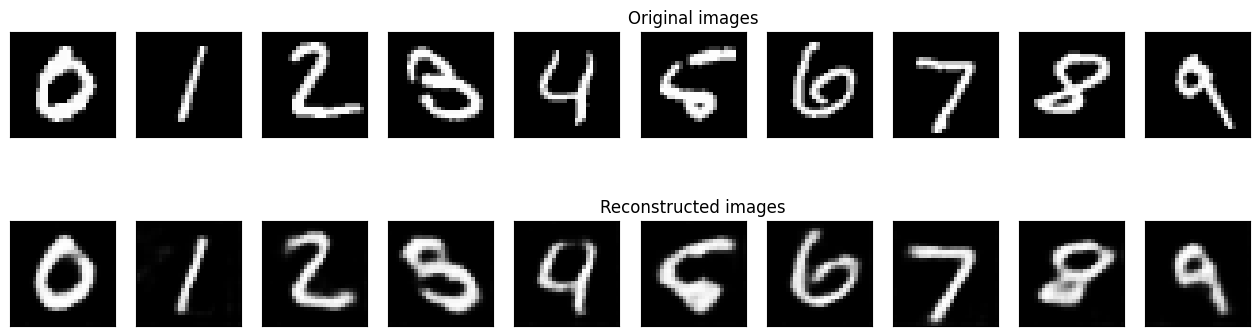


 EPOCH 6/25 	 train loss 0.011614878661930561 	 val loss 0.013391421176493168


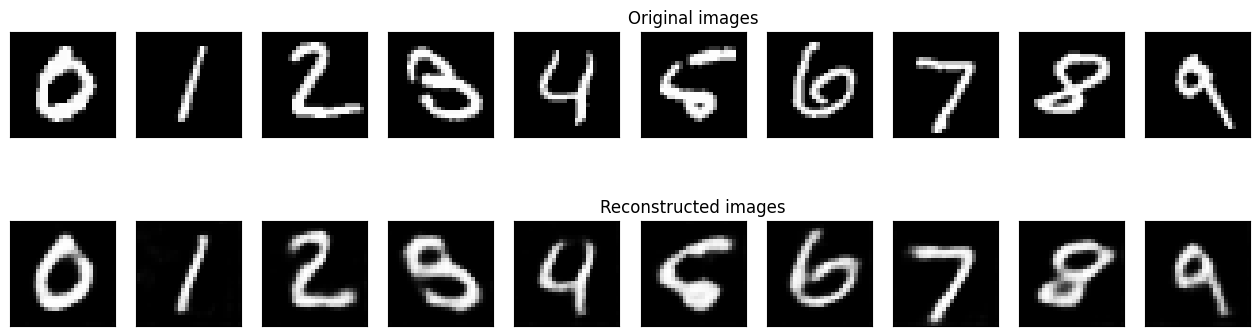


 EPOCH 7/25 	 train loss 0.011541023850440979 	 val loss 0.012406646274030209


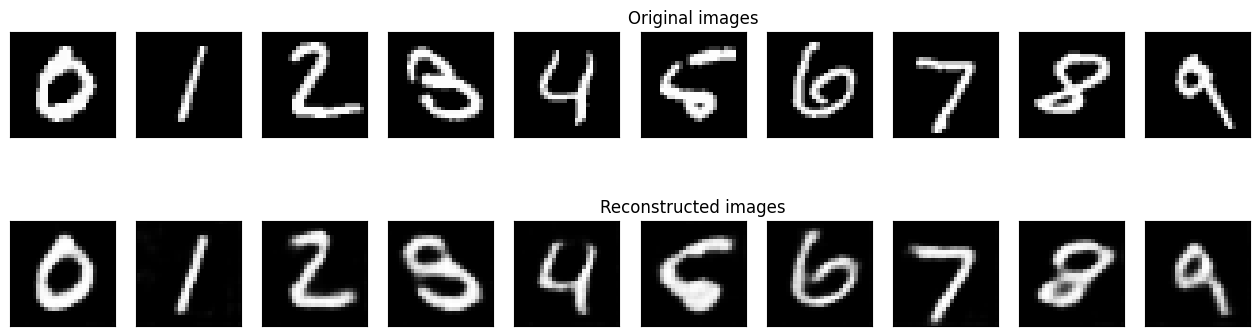


 EPOCH 8/25 	 train loss 0.011379880830645561 	 val loss 0.014206447638571262


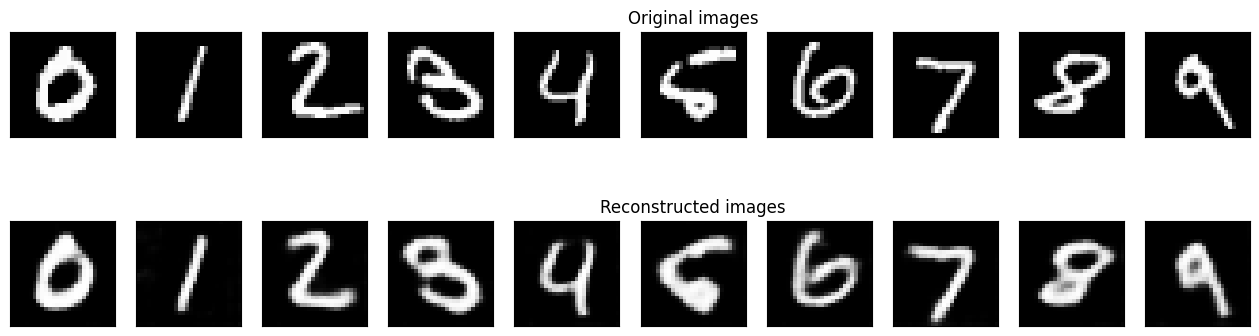


 EPOCH 9/25 	 train loss 0.011261829175055027 	 val loss 0.01163927186280489


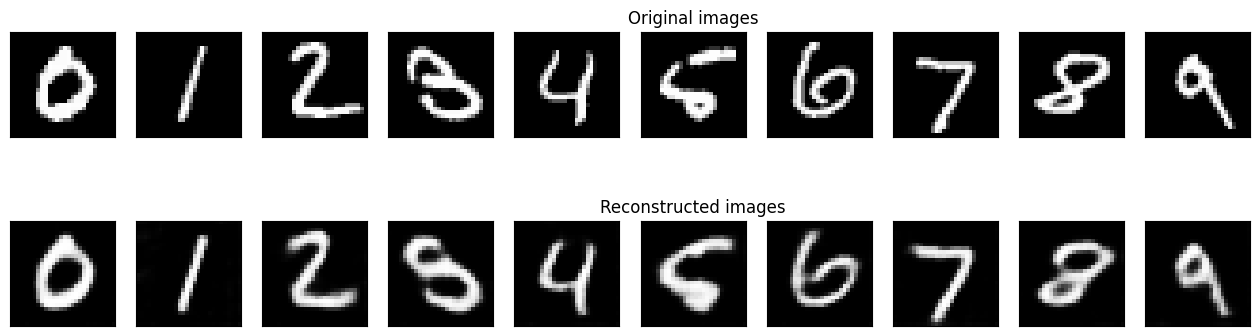


 EPOCH 10/25 	 train loss 0.01110346894711256 	 val loss 0.012325819581747055


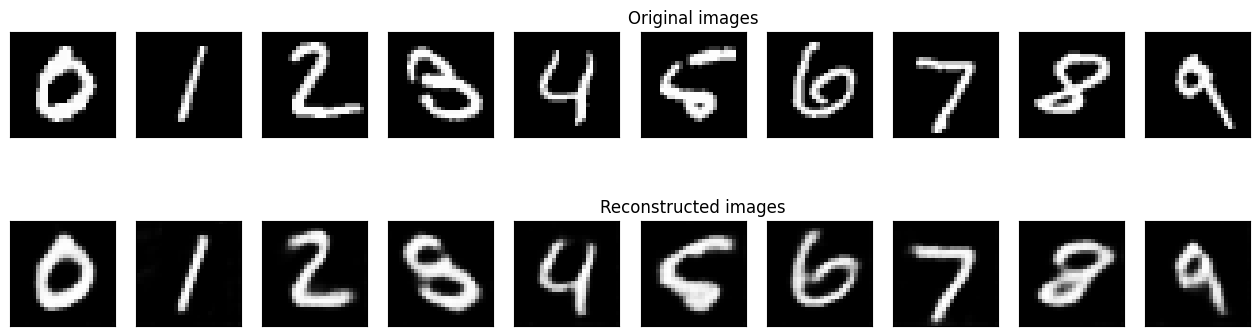


 EPOCH 11/25 	 train loss 0.010823101736605167 	 val loss 0.011411379091441631


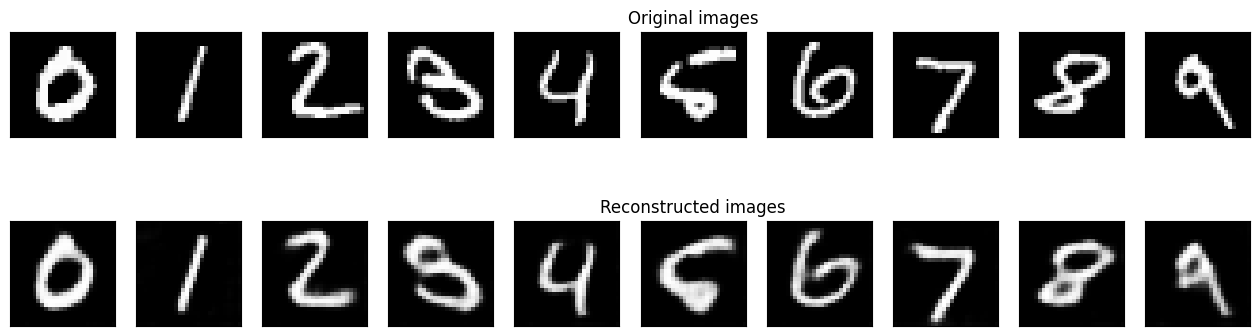


 EPOCH 12/25 	 train loss 0.010594726540148258 	 val loss 0.011922153644263744


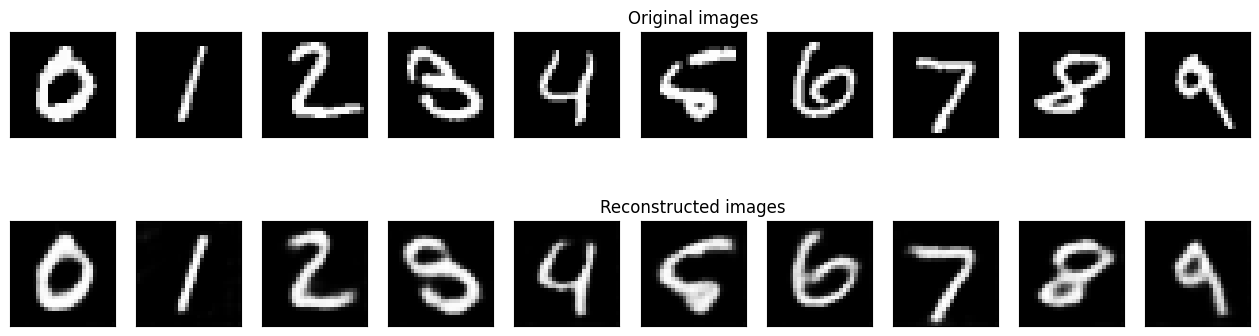


 EPOCH 13/25 	 train loss 0.010485506616532803 	 val loss 0.011153754778206348


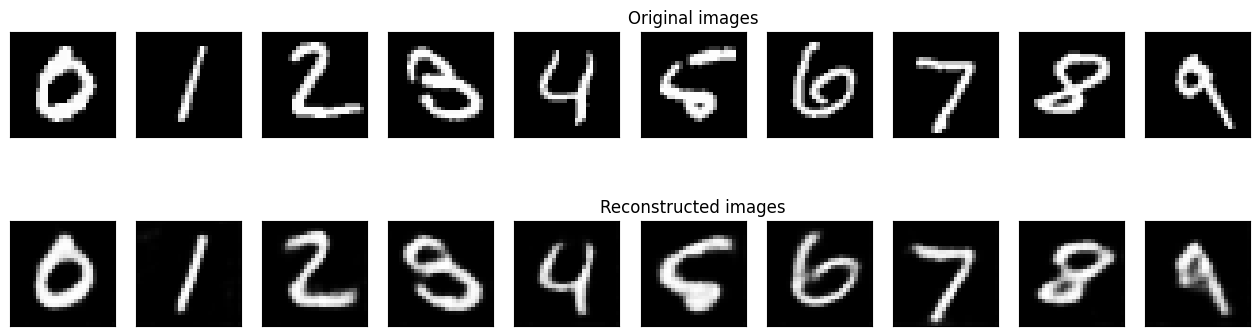


 EPOCH 14/25 	 train loss 0.010674544610083103 	 val loss 0.011748602613806725


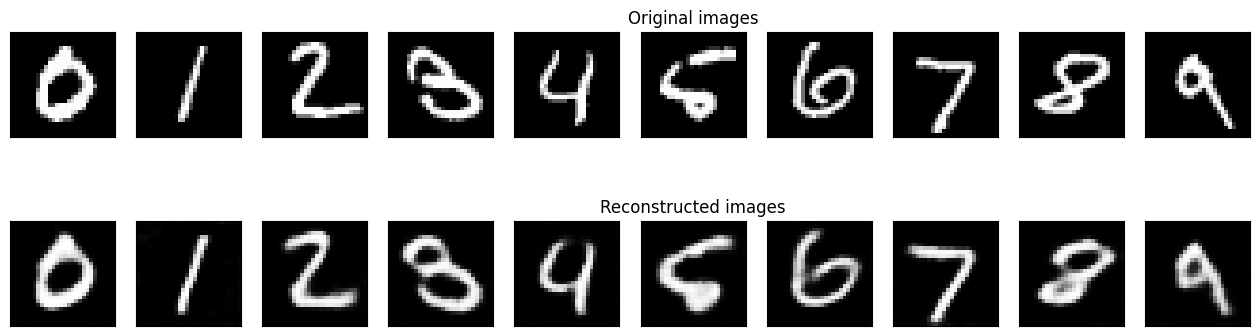


 EPOCH 15/25 	 train loss 0.01037720125168562 	 val loss 0.011787010356783867


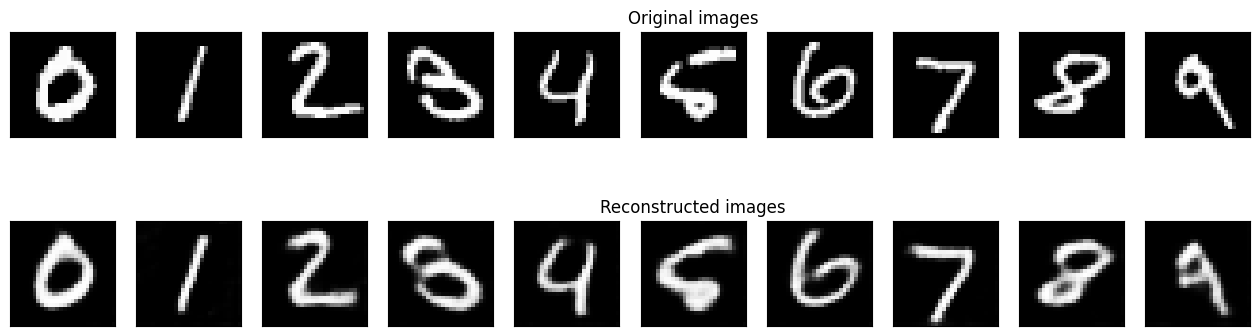


 EPOCH 16/25 	 train loss 0.010634541511535645 	 val loss 0.011740336194634438


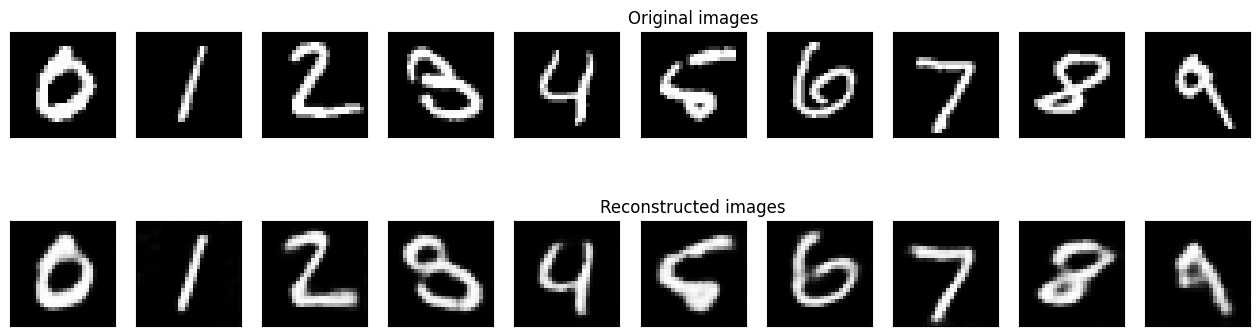


 EPOCH 17/25 	 train loss 0.010336602106690407 	 val loss 0.01082165353000164


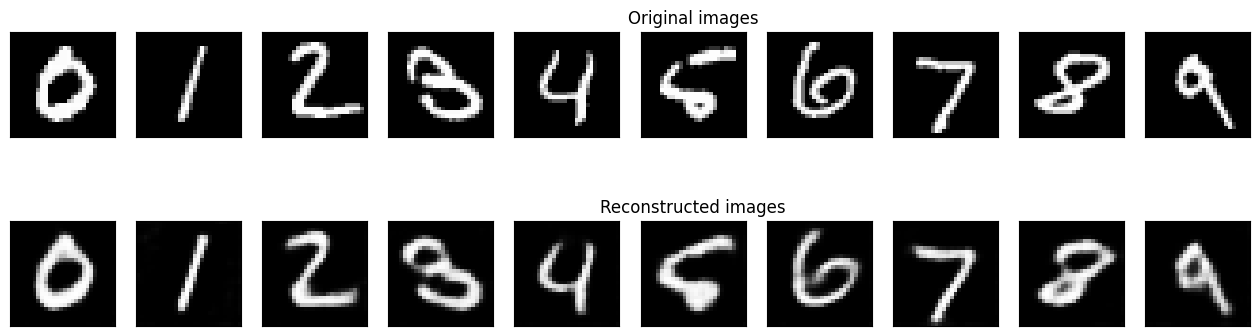


 EPOCH 18/25 	 train loss 0.010219620540738106 	 val loss 0.011165790259838104


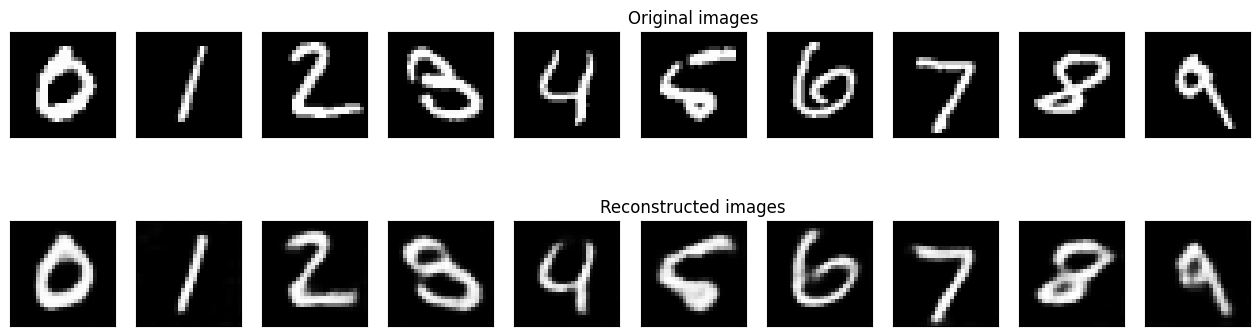


 EPOCH 19/25 	 train loss 0.010410718619823456 	 val loss 0.013255834579467773


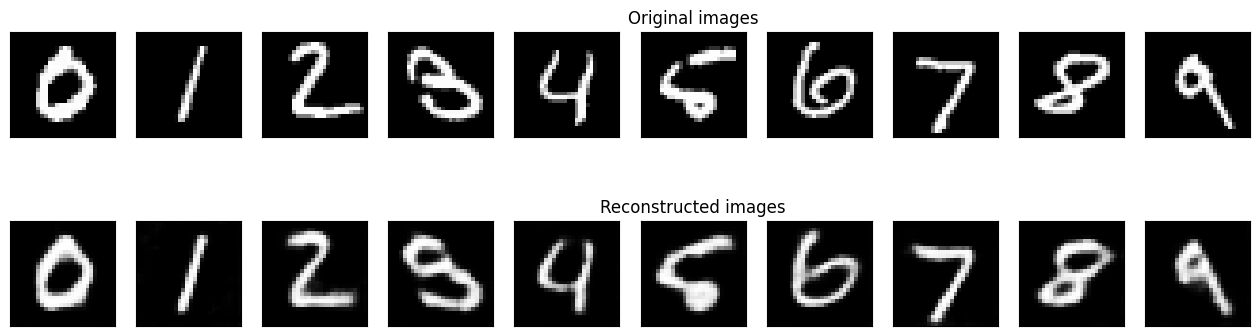


 EPOCH 20/25 	 train loss 0.010191919282078743 	 val loss 0.011594102717936039


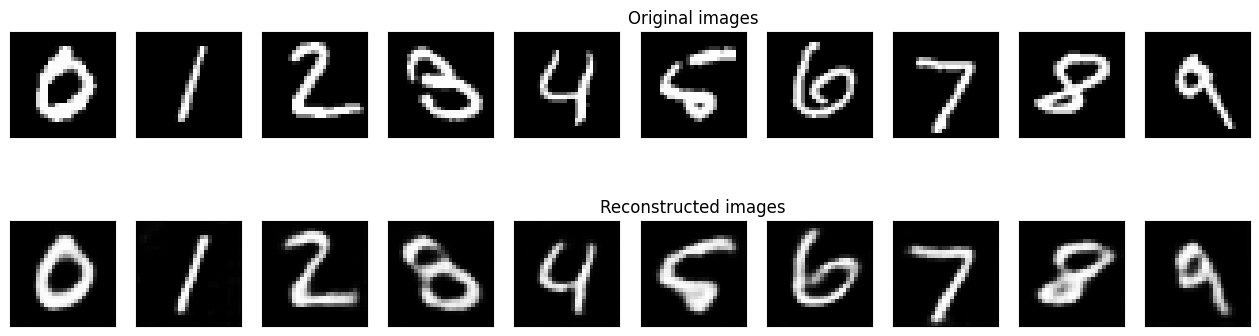


 EPOCH 21/25 	 train loss 0.010189815424382687 	 val loss 0.012056306004524231


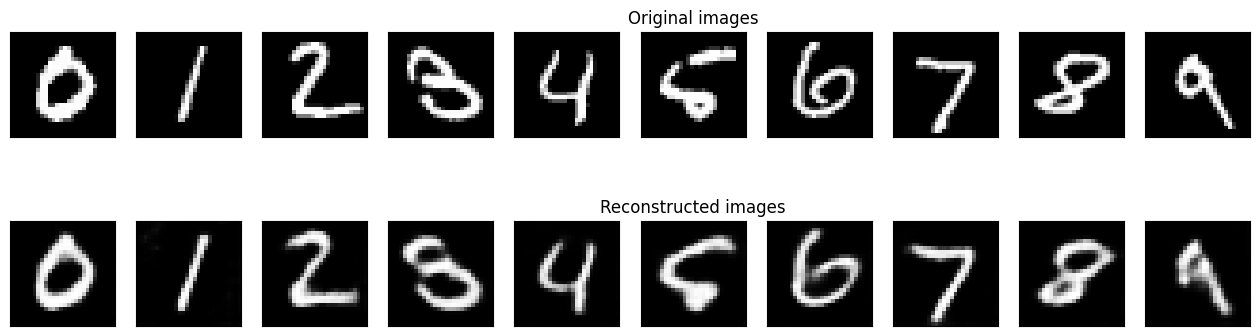


 EPOCH 22/25 	 train loss 0.010030493140220642 	 val loss 0.011106840334832668


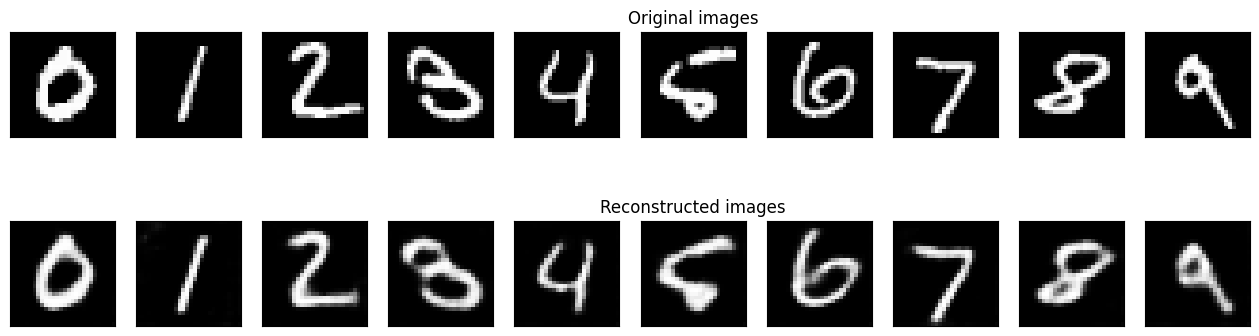


 EPOCH 23/25 	 train loss 0.01019925344735384 	 val loss 0.01025534700602293


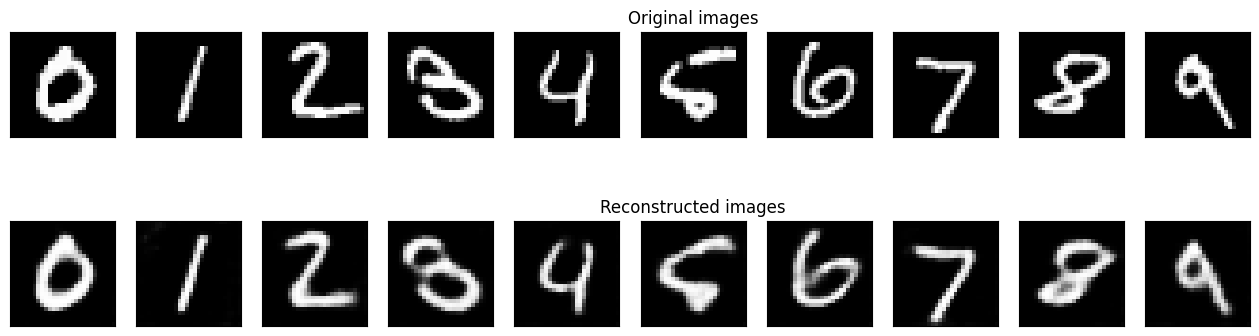


 EPOCH 24/25 	 train loss 0.009987780824303627 	 val loss 0.011246033012866974


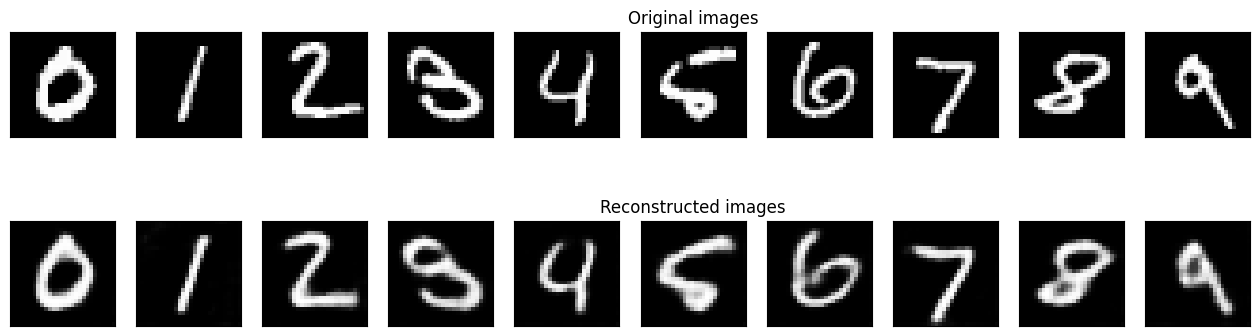


 EPOCH 25/25 	 train loss 0.010094559751451015 	 val loss 0.01115999836474657


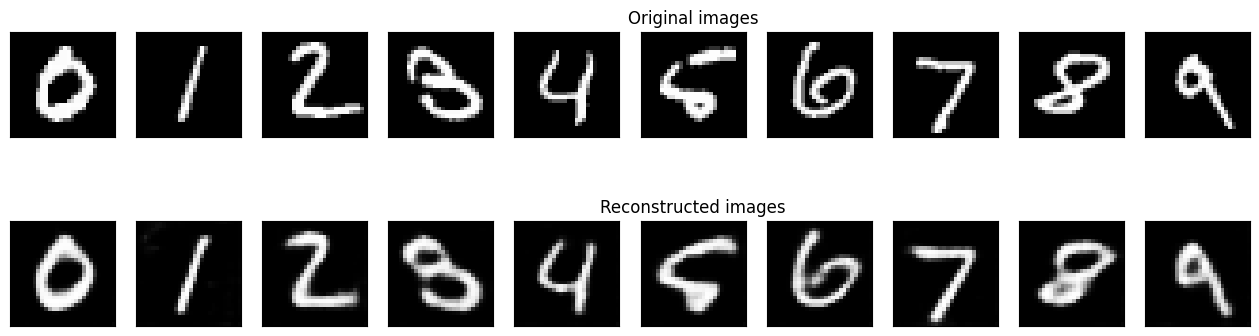

In [10]:
num_epochs = 25
diz_loss = {'train_loss':[],'val_loss':[]}
for epoch in range(num_epochs):
    train_loss =ae.train_epoch(train_loader)
    val_loss = ae.test_epoch(test_loader)
    print('\n EPOCH {}/{} \t train loss {} \t val loss {}'.format(epoch + 1, num_epochs,train_loss,val_loss))
    diz_loss['train_loss'].append(train_loss)
    diz_loss['val_loss'].append(val_loss)
    plot_ae_outputs(ae,n=10)

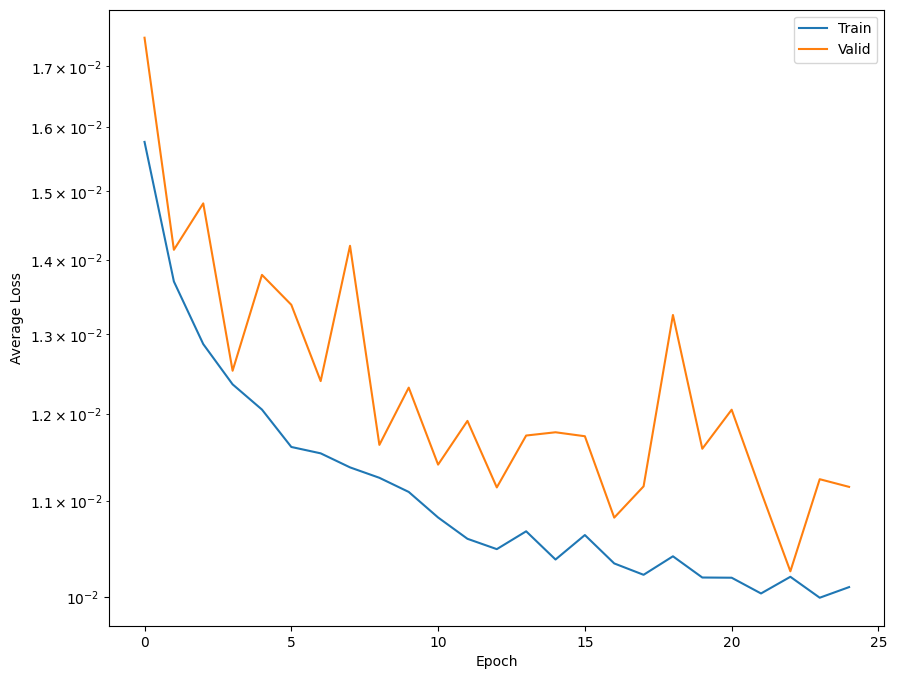

In [11]:
# Plot losses
plt.figure(figsize=(10,8))
plt.semilogy(diz_loss['train_loss'], label='Train')
plt.semilogy(diz_loss['val_loss'], label='Valid')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
#plt.grid()
plt.legend()
#plt.title('loss')
plt.show()

In [ ]:
# TODO view ablation